In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Importing tools
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import datetime
import os
from IPython.display import Image
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
print("TF Version", tf.__version__)
print("TF Hub Version", hub.__version__)

# Check for GPU availability
print("GPU", "available (YES)" if tf.config.list_physical_devices("GPU")else "not available")

TF Version 2.8.2
TF Hub Version 0.12.0
GPU not available


In [9]:
BATCH_SIZE = 32
# Define the image size
IMG_SIZE = 224
labels_csv = pd.read_csv("dogs/labels.csv")
labels = labels_csv['breed'].to_numpy()
unique_breeds = np.unique(labels)

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns image into a Tensor
  """
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numerical Tensor with 3 color channels(RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values (this is called normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (244,244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle if it's validation data
  Also accepts test data as input (no labels, test data does not have labels)
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    # Shuffling pathnames and labels before mapping image procesor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into bathces
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

Loading saved model from: dogs/20220611-23041654988651-full-image-set-mobilenetv2-Adam.h5
Creating test data batches...


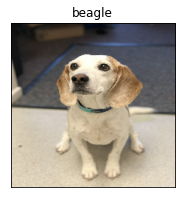

In [10]:
loaded_full_model = load_model("dogs/20220611-23041654988651-full-image-set-mobilenetv2-Adam.h5")

custom_path  = "dogs/dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

custom_data = create_data_batches(custom_image_paths, test_data=True)

custom_preds = loaded_full_model.predict(custom_data)

custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)